In [10]:
import os
import pickle
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from IPython.display import display, Markdown

# Configuración de paths
MODEL_PATH = "models/model_final_12_05.keras"
VOCAB_PATH = "vocab/vocab_final.pkl"


In [11]:

# Función para cargar recursos
def load_resources():

    try:
        # Cargar modelo
        model = load_model(MODEL_PATH, compile=False)
        
        # Cargar vocabulario
        with open(VOCAB_PATH, "rb") as f:
            vocab_data = pickle.load(f)
            vocabulary = vocab_data['vocabulary']
            word_to_idx = vocab_data['word_to_idx']
            idx_to_word = vocab_data['idx_to_word']
            max_seq_length = vocab_data['max_seq_length']
        
        print("✔ Modelo y vocabulario cargados correctamente")
        return model, vocabulary, word_to_idx, idx_to_word, max_seq_length
    
    except Exception as e:
        print(f"❌ Error al cargar recursos: {str(e)}")
        return None, None, None, None, None

# Cargar recursos
model, vocabulary, word_to_idx, idx_to_word, max_seq_length = load_resources()



✔ Modelo y vocabulario cargados correctamente


In [12]:

# Crear encoder
def create_encoder():

    base_model = tf.keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(300, 300, 3),
        pooling='avg'
    )
    
    x = base_model.output
    x = tf.keras.layers.Dense(512, activation='swish', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    return tf.keras.Model(inputs=base_model.input, outputs=x)

encoder = create_encoder()

In [13]:

# ## Generación de Descripciones
def preprocess_image(image_path, target_size=(300, 300)):

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def generate_caption(image_path, beam_size=5):

    # 1. Preprocesamiento seguro de la imagen
    try:
        img = Image.open(image_path)
        img_array = preprocess_image(image_path)
        img_features = encoder.predict(img_array, verbose=0)[0]
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None, "Error al procesar imagen"

    # 2. Verificación del vocabulario durante la generación
    def safe_word_lookup(idx):

        word = idx_to_word.get(idx, None)
        if word is None:
            print(f"⚠️ Índice inválido detectado: {idx}")
            return '<unk>'
        return word

    # 3. Beam search con verificación
    start_token = word_to_idx['<start>']
    end_token = word_to_idx['<end>']
    
    beams = [([start_token], 0.0)]
    valid_sequence = []
    
    for _ in range(max_seq_length):
        new_beams = []
        
        for seq, score in beams:
            if seq[-1] == end_token:
                new_beams.append((seq, score))
                continue
                
            try:
                caption_input = pad_sequences([seq], maxlen=max_seq_length, padding='post')[0]
                preds = model.predict({
                    'image_features': np.array([img_features]),
                    'caption_input': np.array([caption_input])
                }, verbose=0)[0]
                
                # Filtrado de predicciones inválidas
                top_indices = []
                for idx in np.argsort(preds[len(seq)-1])[-beam_size*2:]:
                    word = safe_word_lookup(idx)
                    if word not in ['<unk>', '<pad>']:
                        top_indices.append(idx)
                
                for idx in top_indices[:beam_size]:
                    new_seq = seq + [idx]
                    new_score = score + np.log(preds[len(seq)-1][idx])
                    new_beams.append((new_seq, new_score))
                    
            except Exception as e:
                print(f"Error durante generación: {str(e)}")
                continue
        
        if not new_beams:
            break
            
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        
        # Verificación de secuencia válida
        if beams:
            last_idx = beams[0][0][-1]
            word = safe_word_lookup(last_idx)
            if word not in ['<start>', '<end>', '<unk>', '<pad>']:
                valid_sequence.append(word)

    # 4. Post-procesamiento con verificación
    if not valid_sequence:
        return img, "No se pudo generar descripción válida"
    
    # Reconstrucción segura de la frase
    final_words = []
    for word in valid_sequence:
        if word not in final_words[-2:]:  # Evitar repeticiones inmediatas
            final_words.append(word)
    
    caption = ' '.join(final_words).capitalize()
    return img, caption


In [14]:
def display_image_with_caption(image_path):
    """Muestra la imagen con su descripción generada"""
    img, caption = generate_caption(image_path)
    
    # Crear figura
    plt.figure(figsize=(10, 8))
    
    # Mostrar imagen
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Imagen', pad=20)
    
    # Descripción
    plt.subplot(2, 1, 2)
    plt.text(0.5, 0.5, caption, 
            ha='center', va='center', 
            fontsize=14, wrap=True)
    plt.axis('off')
    plt.title('Descripción Generada')
    
    plt.tight_layout()
    plt.show()

In [15]:
def verify_vocabulary():
    """Verifica la integridad del vocabulario"""
    print("🔍 Diagnóstico del vocabulario:")
    
    # 1. Verificar palabras clave
    test_words = ['dog', 'sea', 'beach', 'car', 'tree', 'snow', 'air']
    print("\n📝 Mapeo de palabras clave:")
    for word in test_words:
        idx = word_to_idx.get(word, -1)
        reverse = idx_to_word.get(idx, "❌ NO EXISTE")
        print(f"'{word}': idx={idx} -> '{reverse}'")

    # 2. Verificar tokens especiales
    print("\n🔤 Tokens especiales:")
    special_tokens = ['<start>', '<end>', '<pad>', '<unk>']
    for token in special_tokens:
        idx = word_to_idx.get(token, -1)
        print(f"{token}: idx={idx}")

    # 3. Estadísticas
    print(f"\n📊 Tamaño del vocabulario: {len(vocabulary)} palabras")
    print(f"Rango de índices: {min(word_to_idx.values())} a {max(word_to_idx.values())}")

verify_vocabulary()

🔍 Diagnóstico del vocabulario:

📝 Mapeo de palabras clave:
'dog': idx=5 -> 'dog'
'sea': idx=680 -> 'sea'
'beach': idx=67 -> 'beach'
'car': idx=44 -> 'car'
'tree': idx=239 -> 'tree'
'snow': idx=12 -> 'snow'
'air': idx=83 -> 'air'

🔤 Tokens especiales:
<start>: idx=0
<end>: idx=1
<pad>: idx=2
<unk>: idx=3

📊 Tamaño del vocabulario: 3473 palabras
Rango de índices: 0 a 3472


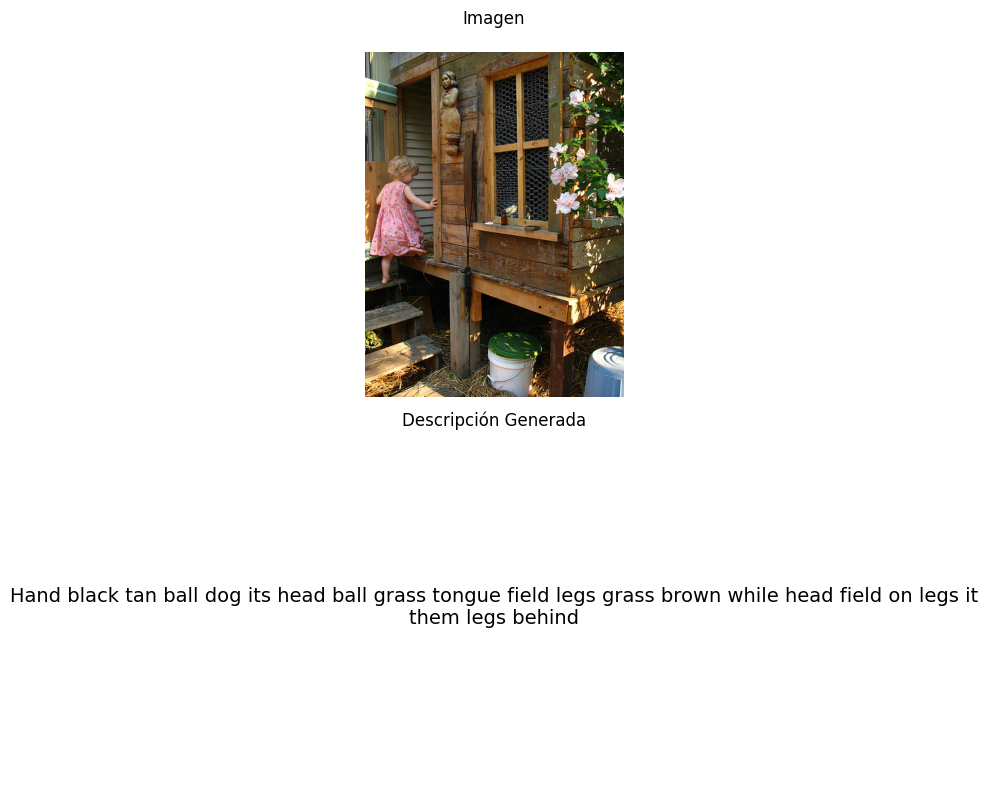

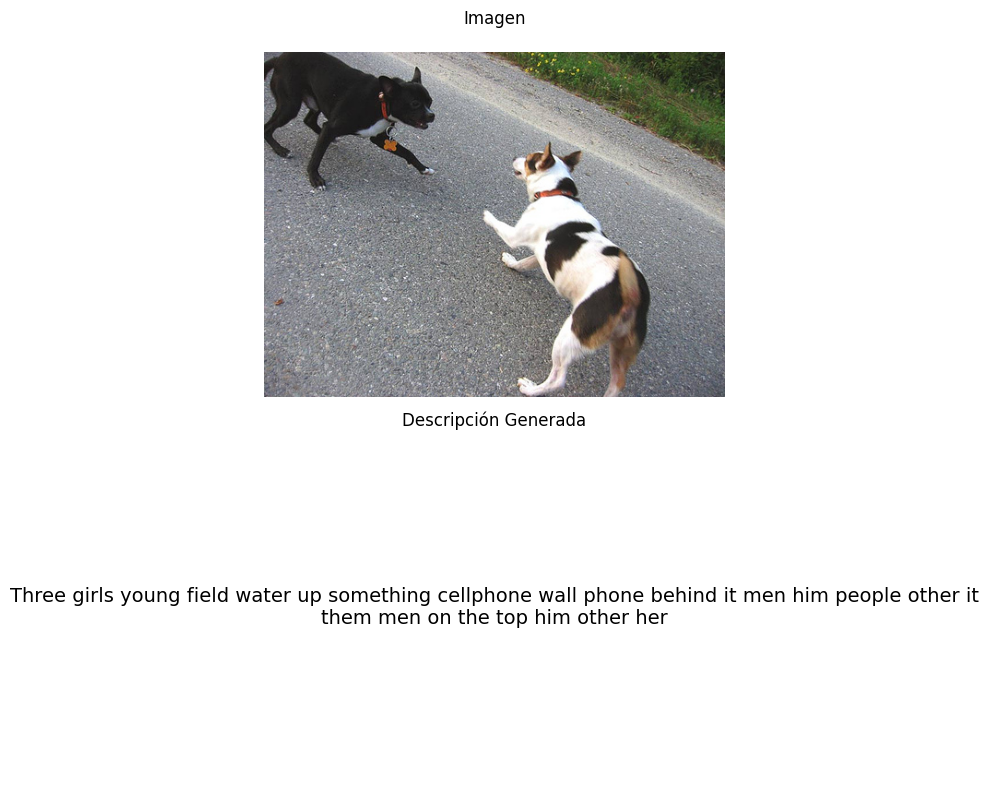

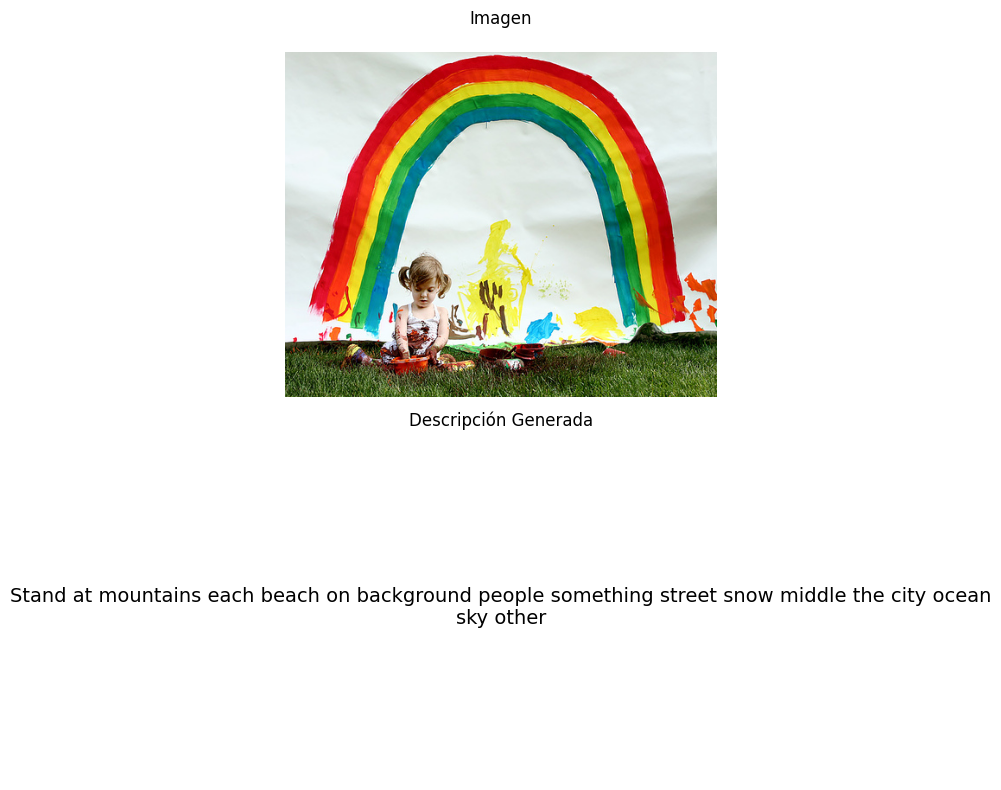

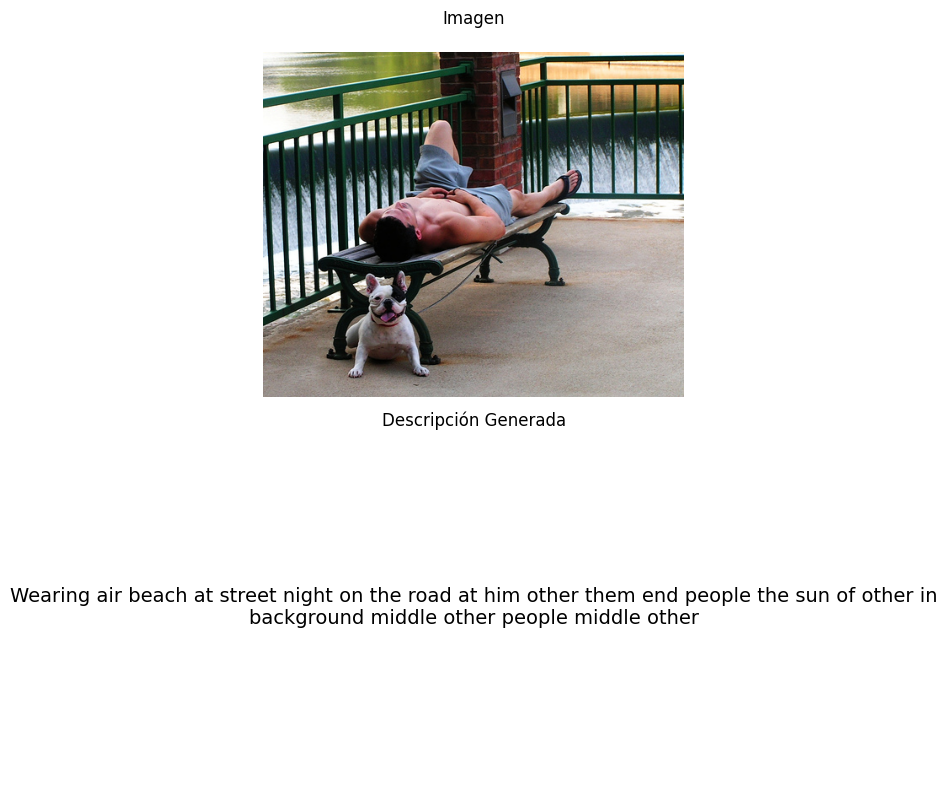

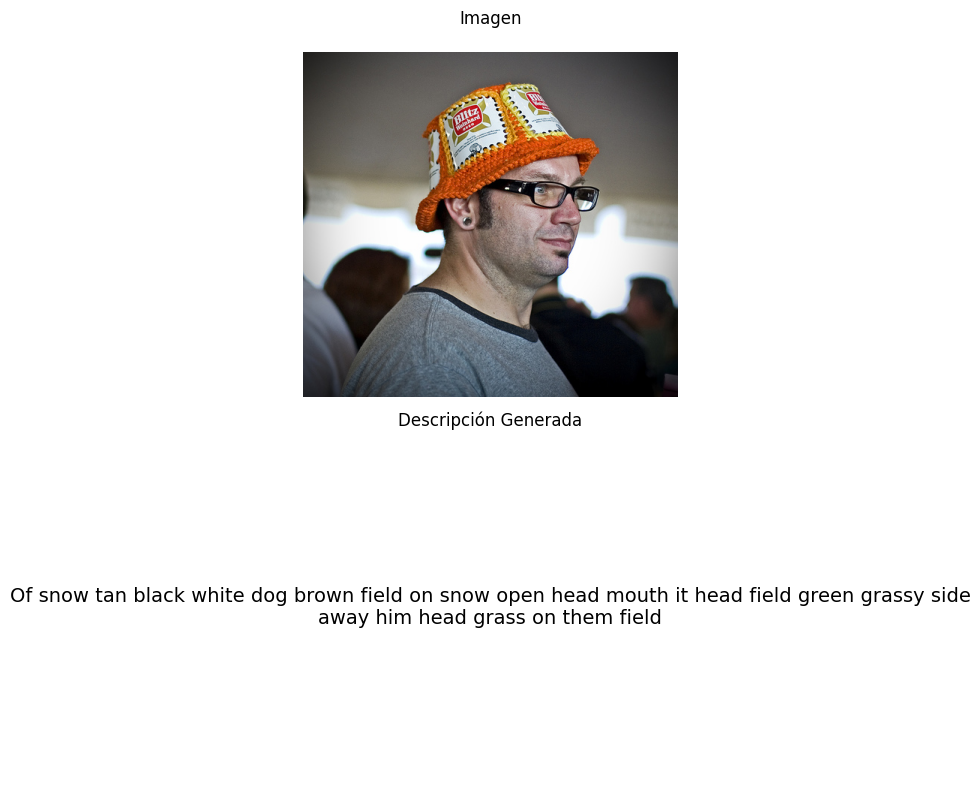

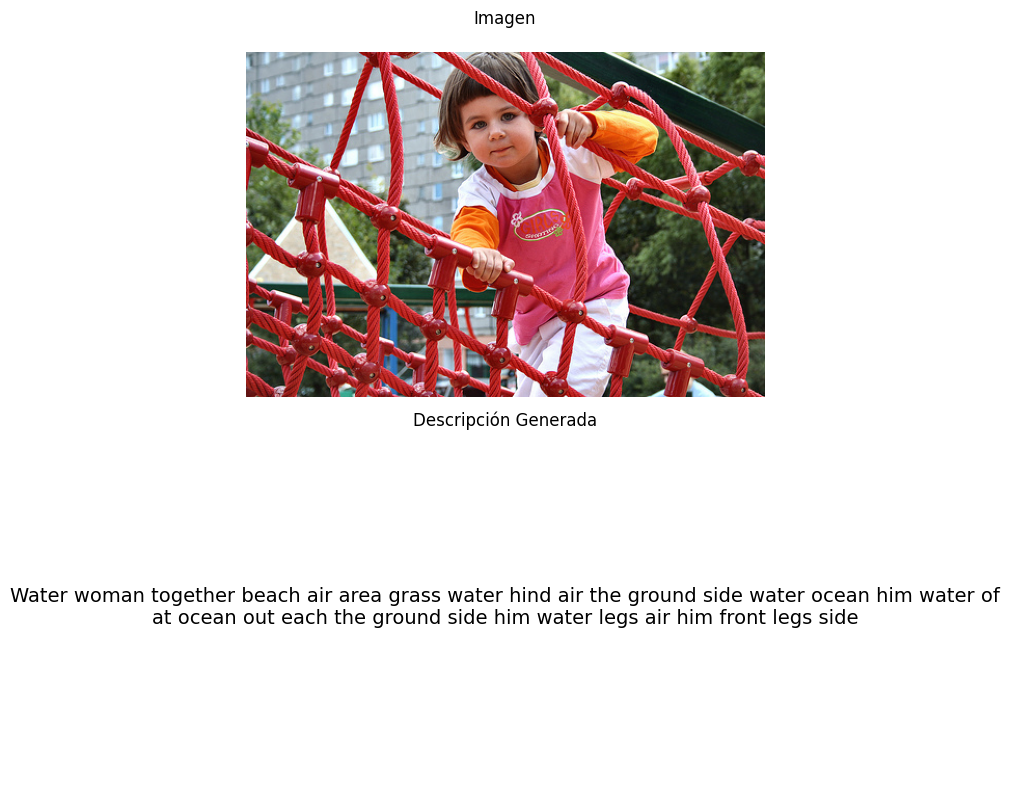

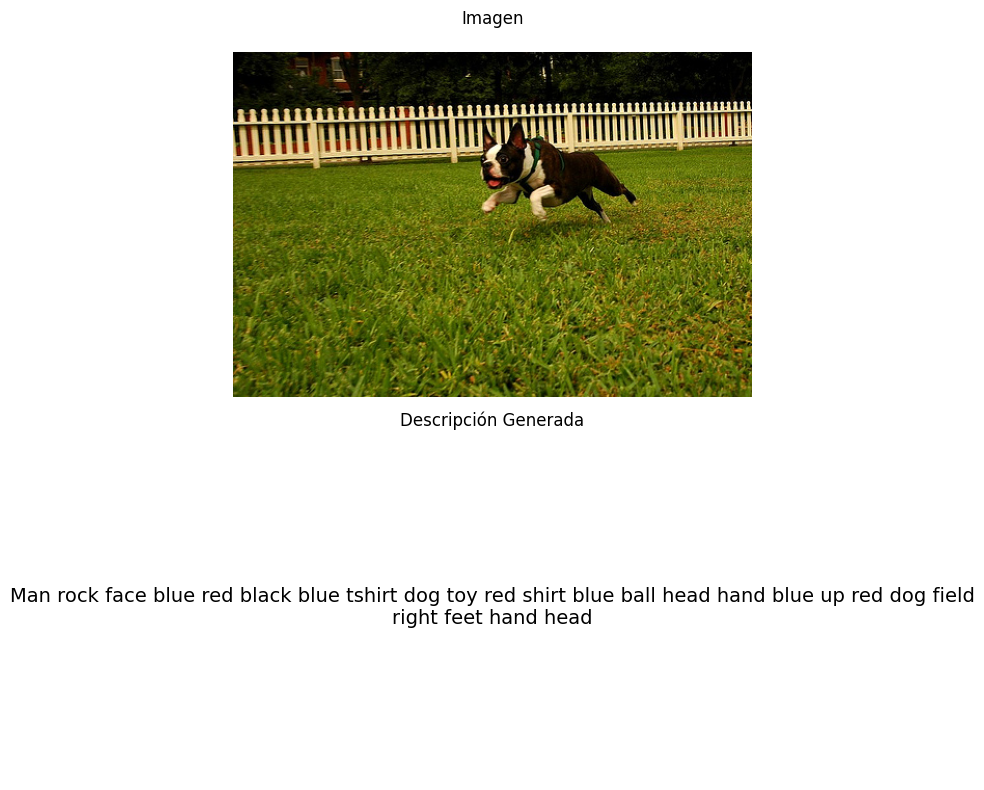

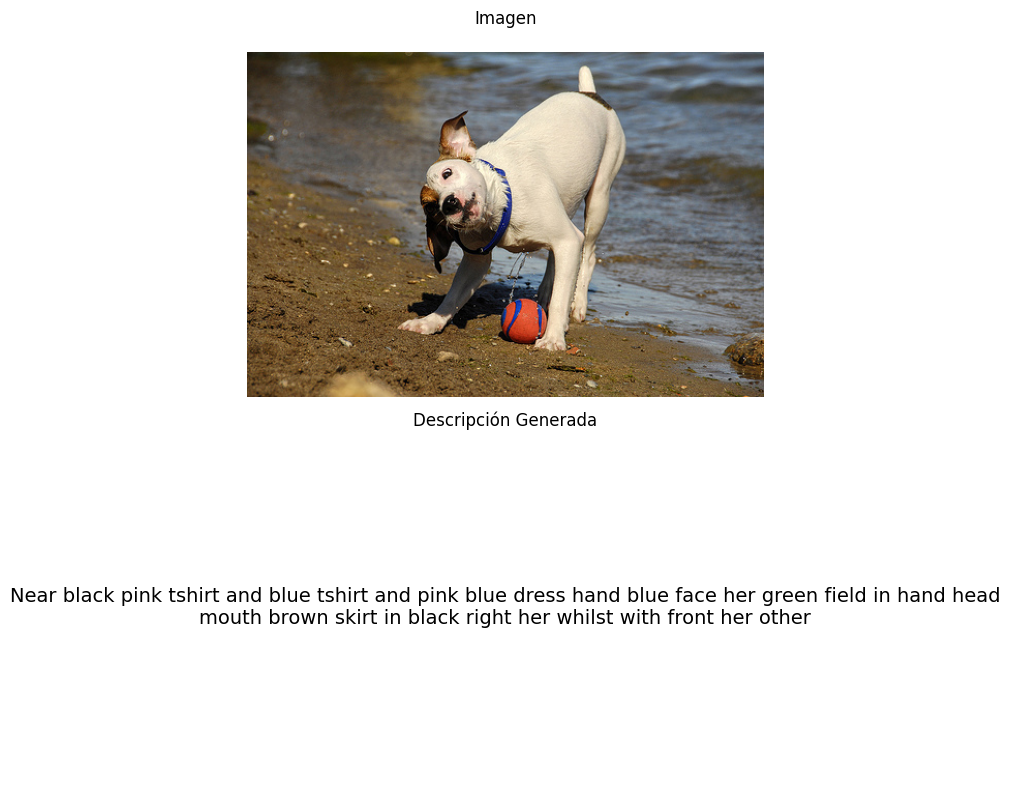

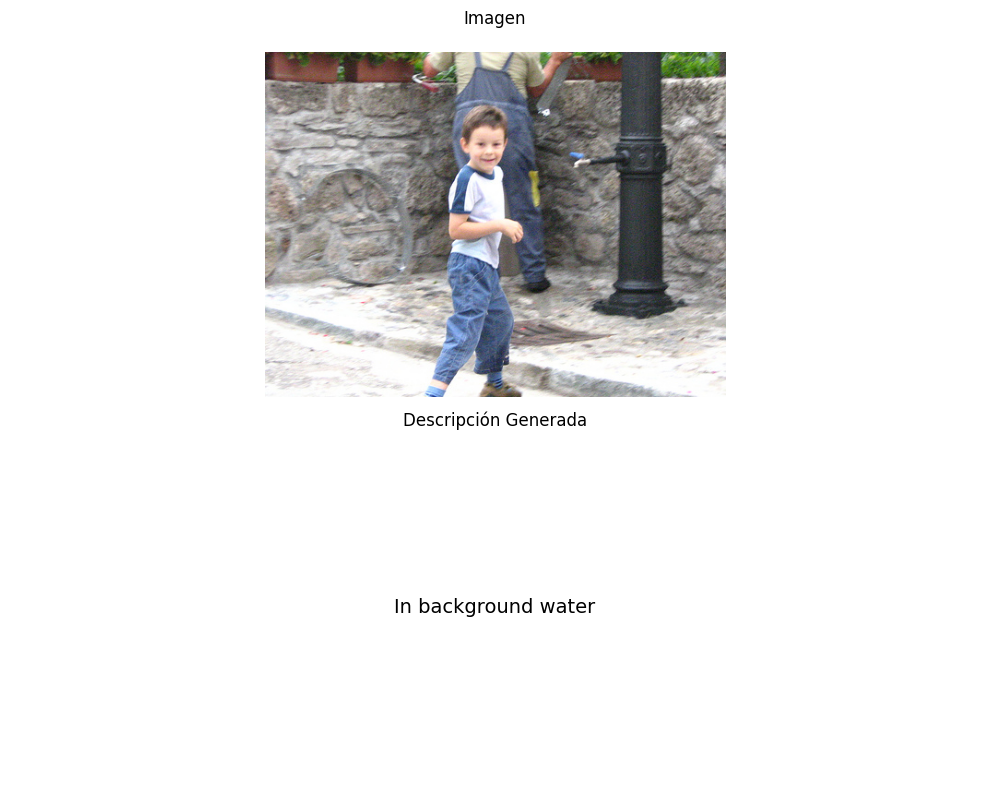

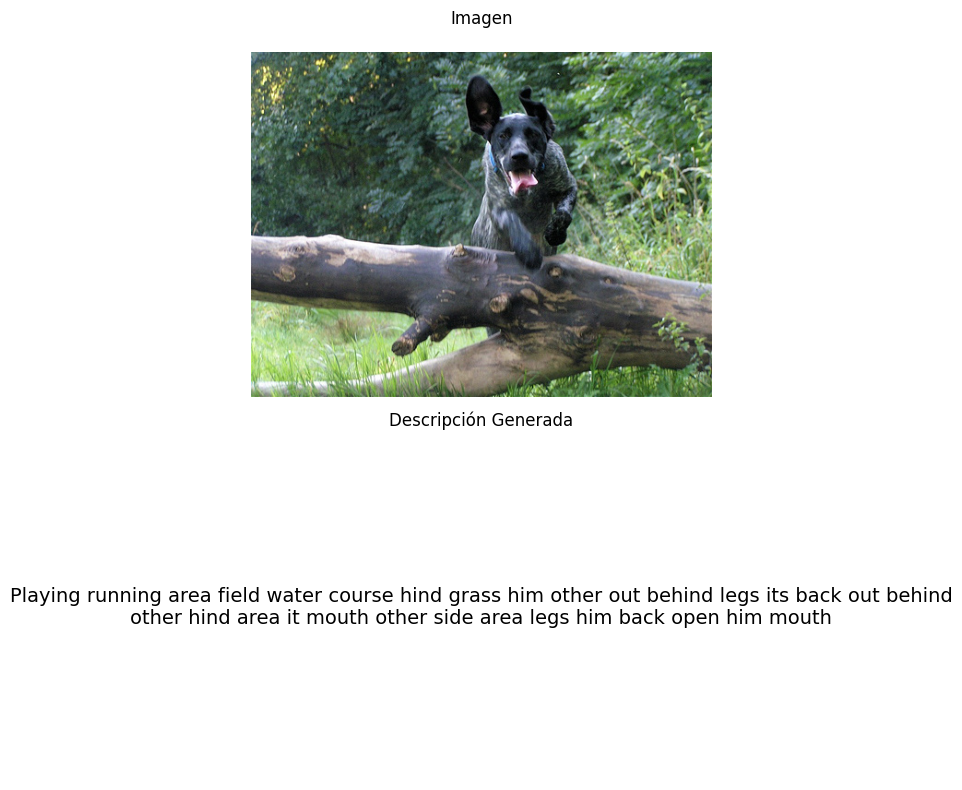

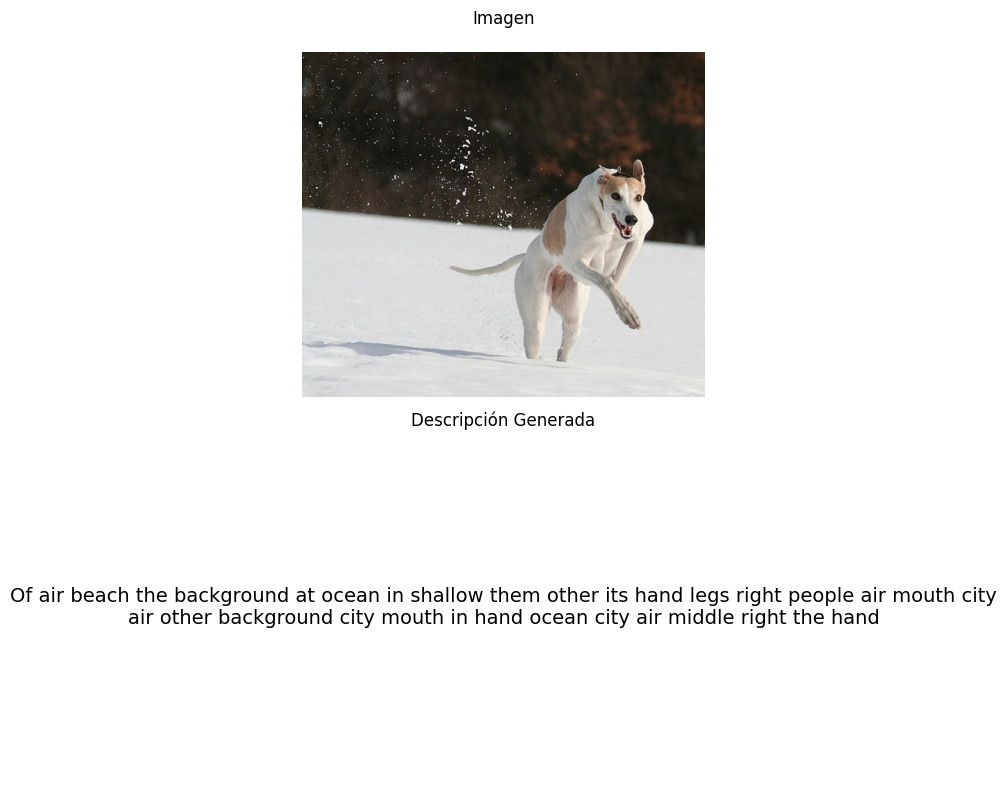

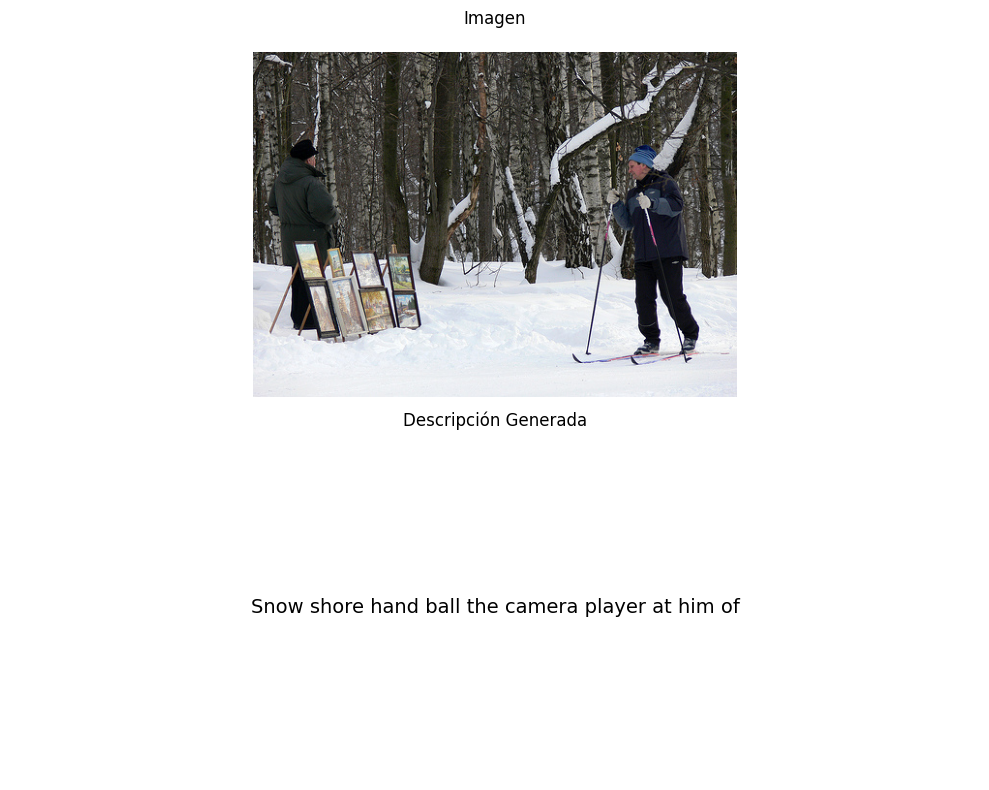

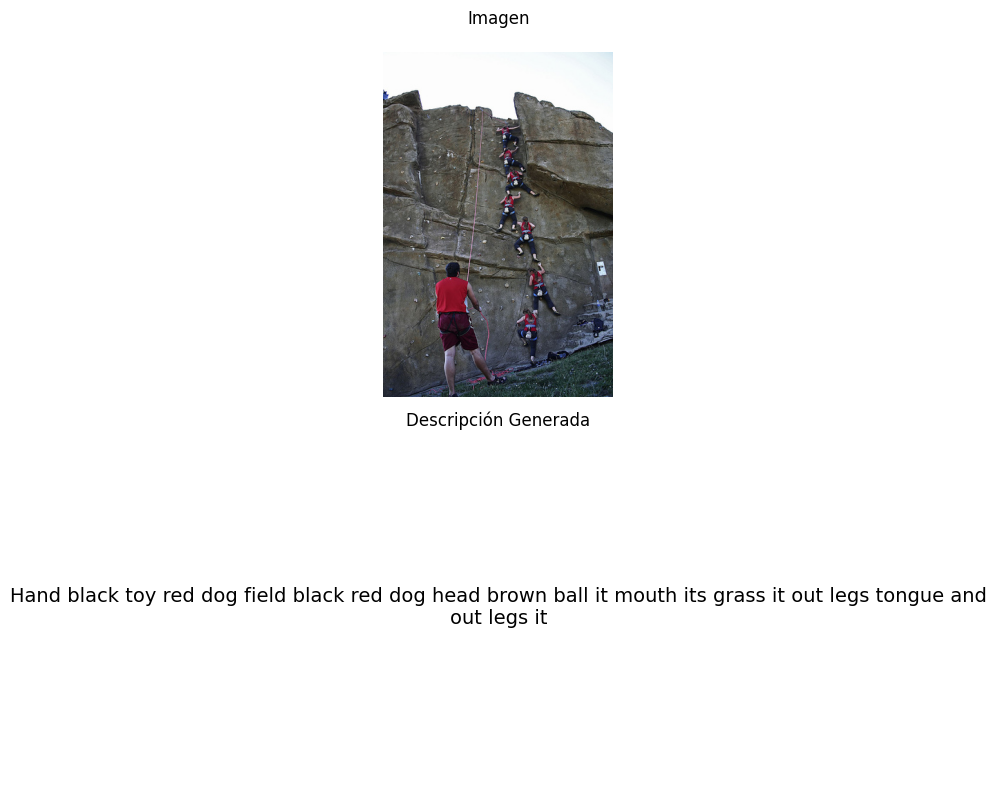

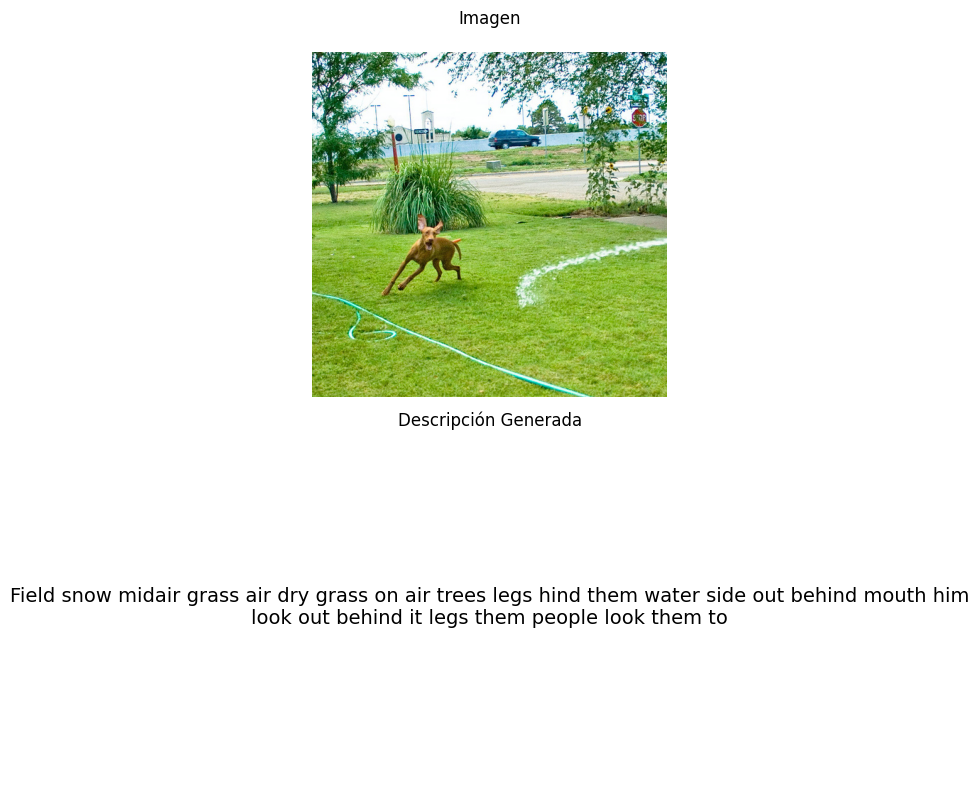

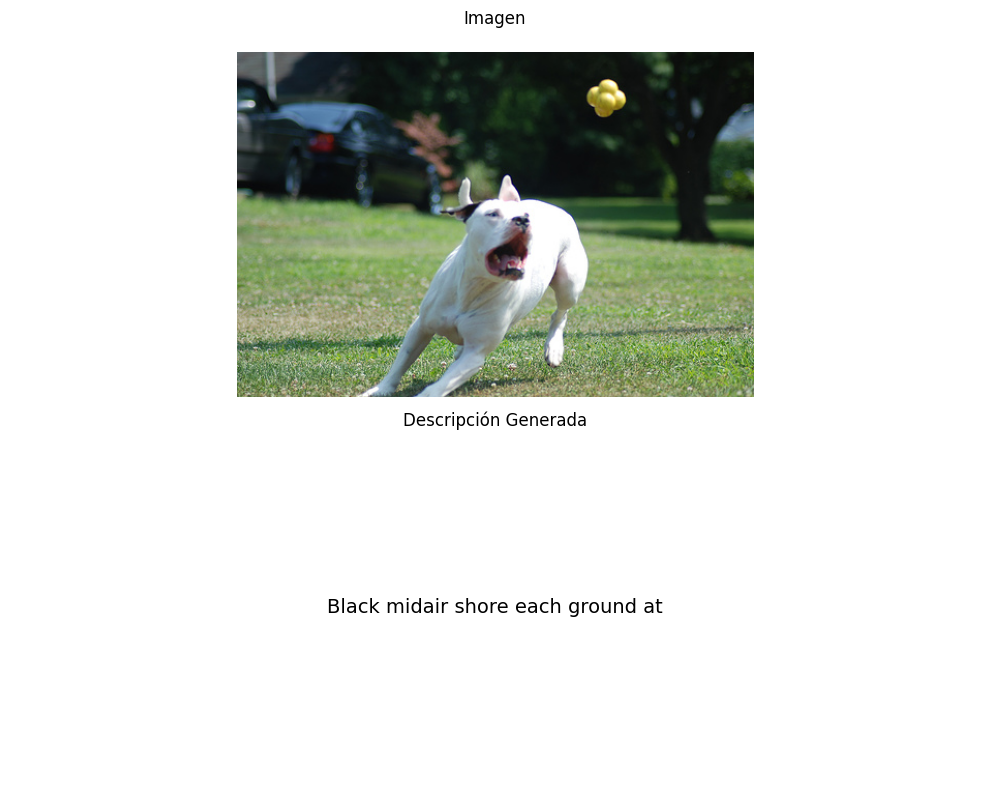

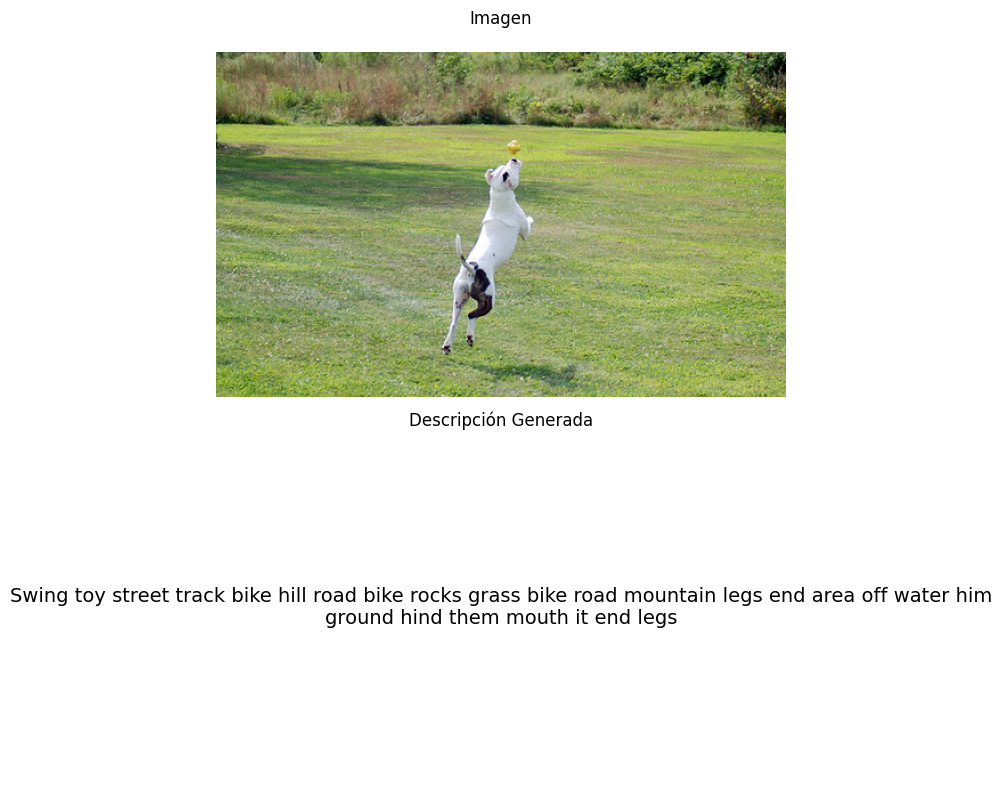

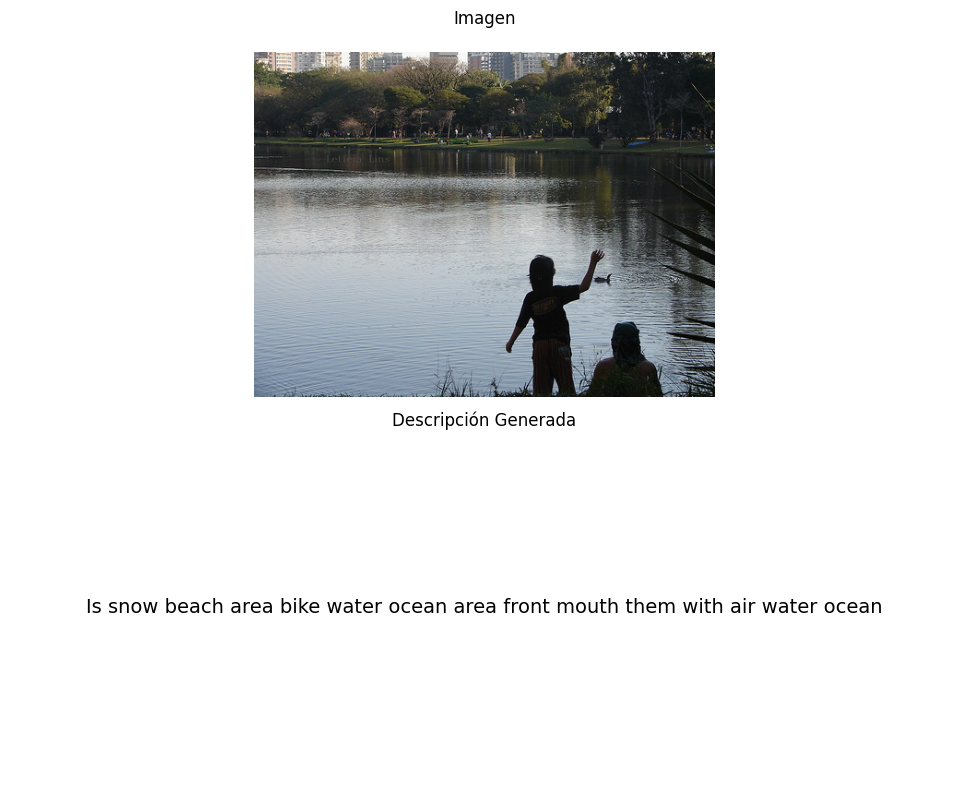

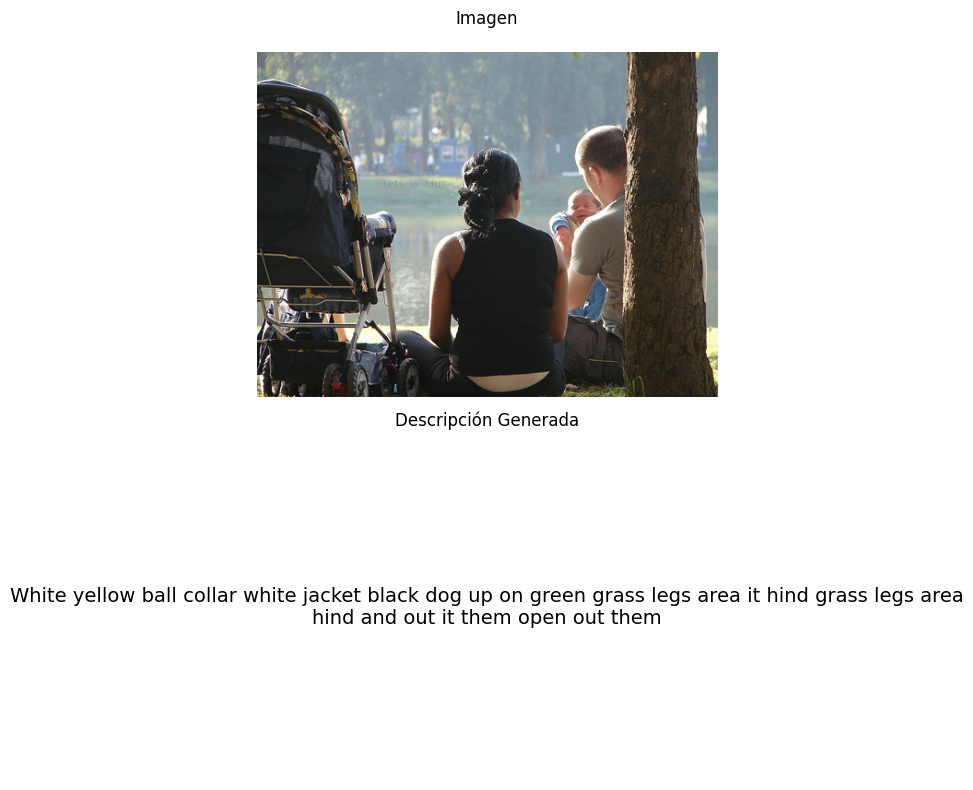

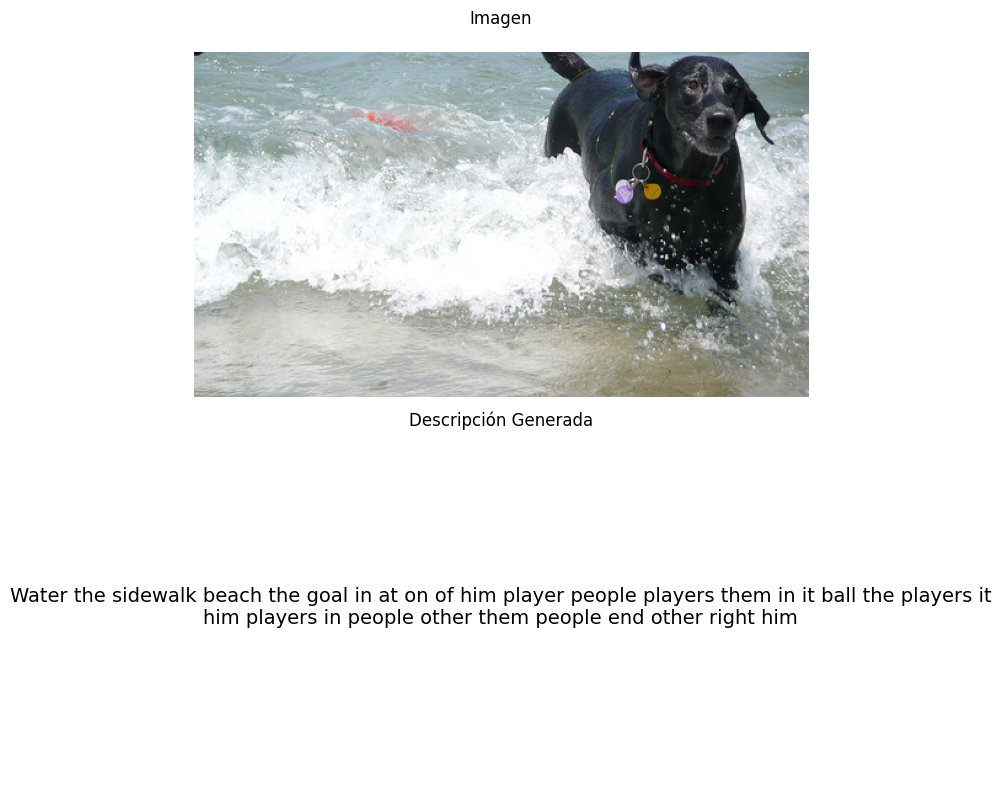

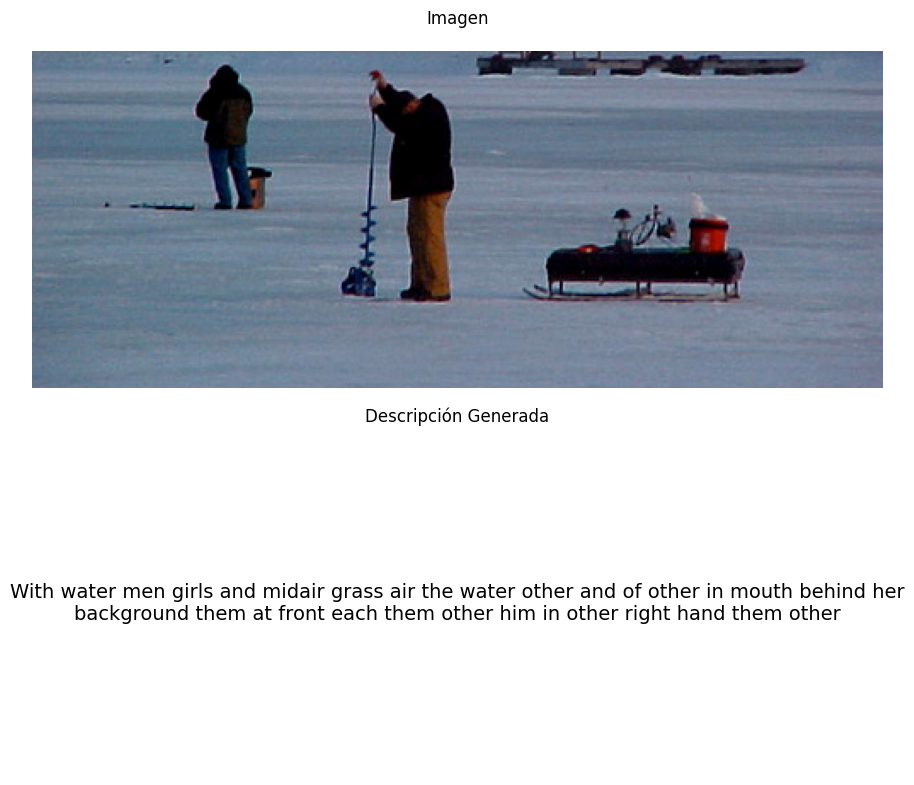

In [16]:
import os

# Ruta de la carpeta donde están las imágenes
folder_path = 'Flickr8k/Flicker8k_Dataset'

all_files = os.listdir(folder_path)
image_files = [file for file in all_files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

first_10_images = image_files[00:20]

for image_file in first_10_images:
    image_path = os.path.join(folder_path, image_file)
    try:
        display_image_with_caption(image_path)  
    except FileNotFoundError:
        print(f"Error: No se encontró la imagen '{image_path}'.")


In [17]:
# ## Evaluación del Modelo

def evaluate_model(test_descriptions, test_features, num_images=10):

    actual = []
    predicted = []
    smoothie = SmoothingFunction().method4
    
    test_ids = list(test_descriptions.keys())[:num_images]
    
    for img_id in test_ids:
        refs = []
        for desc in test_descriptions[img_id]:
            words = [idx_to_word.get(idx, '<unk>') for idx in desc]
            words = [w for w in words if w not in ['<start>', '<end>', '<pad>']]
            refs.append(words)
        actual.append(refs)
        
        img_path = f"Flickr8k/Flicker8k_Dataset/{img_id}.jpg"
        _, caption = generate_caption(img_path)
        predicted.append(word_tokenize(caption.lower()))
    
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    
    return {
        'BLEU-1': bleu1,
        'BLEU-2': bleu2,
        'BLEU-3': bleu3,
        'BLEU-4': bleu4
    }



In [18]:

def plot_metrics(metrics):

    # Gráfico de barras
    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Métricas BLEU del Modelo', pad=20)
    plt.ylabel('Score', labelpad=15)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom')
    
    plt.show()


In [19]:
# Cargar descripciones de prueba
test_descriptions_processed = pickle.load(open("test_descriptions_processed.pkl", "rb"))
# Cargar características de prueba como npy
test_features = np.load("features/test_features_final.npy", allow_pickle=True).item()


FileNotFoundError: [Errno 2] No such file or directory: 'test_descriptions_processed.pkl'

### Métricas de Evaluación

- **BLEU-1**: `0.2900`

- **BLEU-2**: `0.0980`

- **BLEU-3**: `0.0327`

- **BLEU-4**: `0.0155`

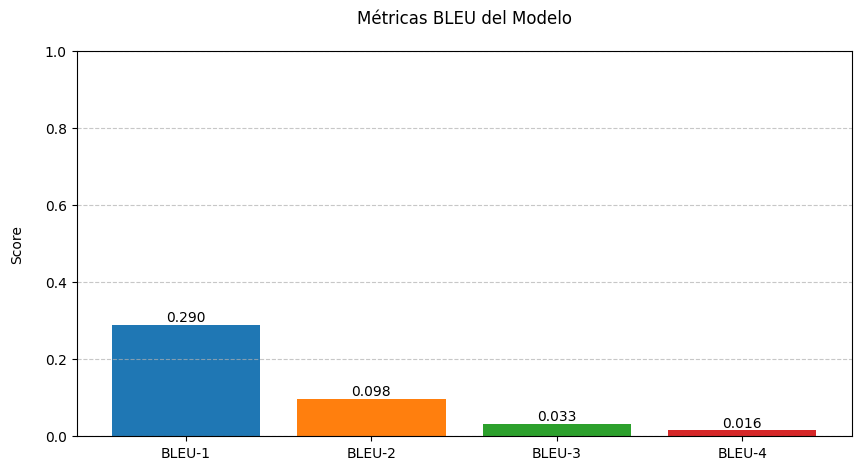

In [ ]:

 # Evaluar el modelo (uso)

try:
    metrics = evaluate_model(test_descriptions_processed, test_features, num_images=20)
    
    display(Markdown("### Métricas de Evaluación"))
    for name, score in metrics.items():
        display(Markdown(f"- **{name}**: `{score:.4f}`"))
    
    plot_metrics(metrics)
    
except Exception as e:
    display(Markdown(f"⚠️ **Error en evaluación**: {str(e)}"))
    display(Markdown("Asegúrate de tener los datos de prueba cargados correctamente"))
